# Setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install polars

In [3]:
import os
import gc
import math
import random
from glob import glob
from collections import defaultdict, Counter
from typing import List, Dict
import joblib
import pickle

from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import polars as pl
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import GroupKFold

## constants

In [4]:
EXP_NAME = "exp115"
DIR = "/content/drive/MyDrive/kddcup2023-ly/kddcup2023"
K_FOLDS = 2
SEED = 42
LOCALES = ["UK", "JP", "DE"]

# This parameter controls to which end item the candidate is tied.
# For example, if [1,2], candidates are generated from the last item and second last item in each session.
LAST_NS = [1, 2, 3]

In [5]:
# Add the gcsfuse repository to the list of repositories
!echo "deb http://packages.cloud.google.com/apt gcsfuse-`lsb_release -c -s` main" | sudo tee /etc/apt/sources.list.d/gcsfuse.list
!curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | sudo apt-key add -

# Install
!apt-get update
!apt-get install gcsfuse

deb http://packages.cloud.google.com/apt gcsfuse-jammy main
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2659  100  2659    0     0  31680      0 --:--:-- --:--:-- --:--:-- 32036
OK
Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Get:2 http://packages.cloud.google.com/apt gcsfuse-jammy InRelease [1,225 B]
Get:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:6 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease [18.1 kB]
Get:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Get:8 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease [24.3 kB]
Get:9 https://ppa.launchpadcontent

In [6]:
%env DATA_ROOT /content/drive/MyDrive/kddcup2023-ly/kddcup2023/data

env: DATA_ROOT=/content/drive/MyDrive/kddcup2023-ly/kddcup2023/data


In [7]:
%env EXP_NAME exp115

env: EXP_NAME=exp115


In [8]:
PARAMS = {
    "objective": "lambdarank",
    "metric": "ndcg",
    "boosting": "gbdt",
    "seed": SEED,
    "num_leaves": 50,
    "max_depth": 10,
    "learning_rate": 0.1,
    "feature_fraction": 0.9,
    "bagging_fraction": 0.9,
    "bagging_freq": 5,
    "min_data_in_leaf": 30,
    "eval_at": [20],
    "lambdarank_truncation_level" : 40,
    "deterministic":True,
}

In [9]:
USE_FEATURES = [
    # === candidate features ===
    "co_visit_weight_last1", "consective_1_weight_last1", "consective_3_weight_last1", "consective_5_weight_last1", "similarity_score_last1", "bert_distance_last1", "lift_last1", "prone_distance_last1",
    "co_visit_weight_last2", "consective_1_weight_last2", "consective_3_weight_last2", "consective_5_weight_last2", "similarity_score_last2", "bert_distance_last2", "lift_last2", "prone_distance_last2",
    "co_visit_weight_last3", "consective_1_weight_last3", "consective_3_weight_last3", "consective_5_weight_last3", "similarity_score_last3", "bert_distance_last3", "lift_last3", "prone_distance_last3",
    "imf_score", "bpr_score",
    "co_visit_rank_last1", "consective_1_rank_last1", "consective_3_rank_last1", "consective_5_rank_last1", "similarity_rank_last1", "bert_rank_last1", "lift_rank_last1", "prone_rank_last1",
    "co_visit_rank_last2", "consective_1_rank_last2", "consective_3_rank_last2", "consective_5_rank_last2", "similarity_rank_last2", "bert_rank_last2", "lift_rank_last2", "prone_rank_last2",
    "co_visit_rank_last3", "consective_1_rank_last3", "consective_3_rank_last3", "consective_5_rank_last3", "similarity_rank_last3", "bert_rank_last3", "lift_rank_last3", "prone_rank_last3",
    "imf_rank", "bpr_rank",
    # === session features ===
    "S_session_length",
    "S_nunique_brand",
    "S_ratio_unique_brand",
    "S_nunique_item",
    "S_ratio_repurchase",
    "S_locale",
    "S_mean_price", "S_max_price", "S_min_price", "S_std_price", "S_total_amount",
    "S_color_not_null_count", "S_size_not_null_count", "S_model_not_null_count", "S_material_not_null_count", "S_author_not_null_count",
    "S_last_item_price",
    # === product features ===
    "P_price",
    "P_purchase_count", "P_purchase_count_global",
    "P_total_amount",
    "P_brand_purchase_count", "P_brand_purchase_count_global",
    "P_brand_mean_price", "P_brand_max_price", "P_brand_min_price", "P_brand_std_price", "P_total_brand_amount",
    "P_price_diff_to_avg_brand_price",
    "P_n_unique_locale",
    "P_is_color_null", "P_is_size_null", "P_is_model_null", "P_is_material_null", "P_is_author_null",
    "P_purchase_count_ratio_to_locale", "P_purchase_amount_ratio_to_locale", "P_purchase_count_ratio_to_brand", "P_purchase_amount_ratio_to_brand",
    # === session * product features ===
    "SP_price_diff_to_mean_price", "SP_price_diff_to_min_price", "SP_price_diff_to_max_price", "SP_price_diff_to_last_price",
    "SP_brand_price_diff_to_mean_price", "SP_brand_price_diff_to_min_price", "SP_brand_price_diff_to_max_price", "SP_brand_price_diff_to_last_price",
    "SP_same_brand_last1", "SP_same_brand_last2", "SP_same_brand_last3",
    "SP_same_color_last1", "SP_same_color_last2", "SP_same_color_last3",
    "SP_same_size_last1", "SP_same_size_last2", "SP_same_size_last3",
    "SP_same_model_last1", "SP_same_model_last2", "SP_same_model_last3",
    "SP_same_material_last1", "SP_same_material_last2", "SP_same_material_last3",
    "SP_same_author_last1", "SP_same_author_last2", "SP_same_author_last3",
    "SP_same_brand_sum", "SP_same_color_sum", "SP_same_size_sum", "SP_same_model_sum", "SP_same_material_sum", "SP_same_author_sum",
    # === similality features ===
    "imf_similarity", "bpr_similarity",
    "graph_emb_similarity_last1", "graph_emb_similarity_last2", "graph_emb_similarity_last3",
    "i2v_similarity_last1", "i2v_similarity_last2", "i2v_similarity_last3",
]

## functions

In [10]:
# functions for model training, prediction and evaluation

def train_lgb_model(train:pd.DataFrame) -> np.array:
    feat_imp = np.zeros((len(USE_FEATURES),))
    gkf = GroupKFold(n_splits=K_FOLDS)
    for fold, (train_idx, val_idx) in enumerate(gkf.split(train, train["label"], groups=train["session_id"])):
        print(f'Fold {fold+1}')

        # Split data into train and validation sets
        train_tmp = train.iloc[train_idx].copy()
        valid_tmp = train.iloc[val_idx].copy()
        train_tmp.sort_values("session_id", inplace=True)
        valid_tmp.sort_values("session_id", inplace=True)
        train_baskets = train_tmp.groupby("session_id")["candidate_item"].count().values
        valid_baskets = valid_tmp.groupby("session_id")["candidate_item"].count().values
        X_train, y_train = train_tmp[USE_FEATURES], train_tmp["label"]
        X_val, y_val = valid_tmp[USE_FEATURES], valid_tmp["label"]

        # Create LightGBM dataset
        lgb_train = lgb.Dataset(X_train, y_train, group=train_baskets)
        lgb_val = lgb.Dataset(X_val, y_val, group=valid_baskets, reference=lgb_train)

        del train_tmp, valid_tmp, X_train, y_train, train_baskets, X_val, y_val, valid_baskets
        gc.collect()

        # Train LightGBM model
        model = lgb.train(PARAMS,
                        lgb_train,
                        num_boost_round=10000,
                        valid_sets=[lgb_train, lgb_val],
                        callbacks=[
                            lgb.early_stopping(stopping_rounds=50),
                            lgb.log_evaluation(100),
                        ]
                )

        # Save LightGBM model
        joblib.dump(model, f'/content/drive/MyDrive/kddcup2023/models/task1/{EXP_NAME}_{fold+1}.pkl')

        # Add feature importance scores
        feat_imp += model.feature_importance(importance_type="gain")

    return feat_imp

## fix seed

In [11]:
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
seed_everything(SEED)

# Train

## train model

In [12]:
files = glob(f"/content/drive/MyDrive/kddcup2023-ly/kddcup2023/data/interim/for_ranker/task1/train_chunk_{EXP_NAME}_*")
files = files[:10]
dfs = []
for f in tqdm(files):
    dfs.append(pd.read_parquet(f))
train = pd.concat(dfs)
del dfs; gc.collect()

100%|██████████| 10/10 [01:19<00:00,  7.94s/it]


0

In [19]:
def display_specific_columns(dataframe):
    # 取前1列和后4列
    columns_to_display = dataframe.columns.tolist()[:1] + dataframe.columns.tolist()[-4:]
    # 使用.loc来选择需要展示的列
    display_df = dataframe.loc[:, columns_to_display]

    # 在显示之前，你可以自定义如何表示被省略的列，这里我用"..."来表示
    # print("Displaying first column and last four columns:")
    # print("...")
    # print(display_df)
    display_df.head()

In [20]:
train = train[["session_id", "candidate_item", "label"] + USE_FEATURES]

In [21]:
display_specific_columns(train)

In [ ]:
train.head()

,session_id,candidate_item,label,co_visit_weight_last1,consective_1_weight_last1,consective_3_weight_last1,consective_5_weight_last1,similarity_score_last1,bert_distance_last1,lift_last1,...,SP_same_material_sum,SP_same_author_sum,imf_similarity,bpr_similarity,graph_emb_similarity_last1,graph_emb_similarity_last2,graph_emb_similarity_last3,i2v_similarity_last1,i2v_similarity_last2,i2v_similarity_last3
0,train_1,B001B4THSA,1,19.10,6,6,6,0.516778,0.103985,1.910000,...,0,0,0.193230,0.0,0.792757,0.731243,0.268386,0.983131,0.901155,0.699726
1,train_3,B0B4R9NN4B,1,0.00,0,0,0,0.000000,-1.000000,0.000000,...,0,0,0.101819,0.0,0.976244,0.987364,0.985802,0.989610,0.966605,0.962165
2,train_4,B0BGVBKWGZ,1,0.00,0,0,0,0.000000,-1.000000,0.000000,...,0,0,0.047979,0.0,0.713439,0.665361,0.663519,0.816075,0.862360,0.830845
3,train_5,B0749TX4YS,1,9.75,3,4,4,0.864205,0.037787,0.790829,...,3,0,0.246166,0.0,0.945820,0.848091,0.838902,0.960843,0.969533,0.939104
4,train_7,B097CX2V3L,1,3.00,1,1,1,0.596653,0.205700,2.121320,...,0,0,0.229655,0.0,0.997039,0.913595,0.787737,0.932054,0.578067,0.647563


In [ ]:
filtered_df = train[train['session_id'] == 'train_8']
filtered_df.head()

,session_id,candidate_item,label,co_visit_weight_last1,consective_1_weight_last1,consective_3_weight_last1,consective_5_weight_last1,similarity_score_last1,bert_distance_last1,lift_last1,...,SP_same_material_sum,SP_same_author_sum,imf_similarity,bpr_similarity,graph_emb_similarity_last1,graph_emb_similarity_last2,graph_emb_similarity_last3,i2v_similarity_last1,i2v_similarity_last2,i2v_similarity_last3
5,train_8,B09B32SSDT,1,6.0,2,2,2,0.685383,0.132845,1.732051,...,0,0,0.187060,0.0,0.960128,0.912044,0.943177,0.984076,0.887403,0.928522
39737,train_8,B08T653XYP,0,0.0,0,0,0,0.000000,-1.000000,0.000000,...,0,0,0.047843,0.0,-0.025636,-0.015127,0.009304,0.623722,0.512112,0.515651
39741,train_8,B07NZWHVS4,0,0.0,0,0,0,0.000000,-1.000000,0.000000,...,0,0,0.081445,0.0,0.898909,0.868923,0.913593,0.975685,0.861076,0.900390
39745,train_8,B09ZBBH722,0,0.0,0,0,0,0.000000,-1.000000,0.000000,...,0,0,0.072150,0.0,0.620209,0.808888,0.653429,0.875337,0.926810,0.948983
39754,train_8,B09TH1HQQP,0,0.0,0,0,0,0.000000,-1.000000,0.000000,...,0,0,0.026414,0.0,-0.190299,0.091184,-0.163530,0.919142,0.712906,0.718971


In [ ]:
next_item = filtered_df['next_item'].iloc[0]

KeyError: 'next_item'

In [ ]:
filtered_df.shape

(42, 134)

Fold 1
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.353721 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18023
[LightGBM] [Info] Number of data points in the train set: 9406315, number of used features: 129
Training until validation scores don't improve for 50 rounds
[100]	training's ndcg@20: 0.774557	valid_1's ndcg@20: 0.767275
[200]	training's ndcg@20: 0.784881	valid_1's ndcg@20: 0.769608
[300]	training's ndcg@20: 0.792795	valid_1's ndcg@20: 0.76983
[400]	training's ndcg@20: 0.799316	valid_1's ndcg@20: 0.769951
Early stopping, best iteration is:
[371]	training's ndcg@20: 0.797506	valid_1's ndcg@20: 0.770022
Fold 2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.368676 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=

[Text(0.5, 1.0, 'Feature Importance TOP25')]

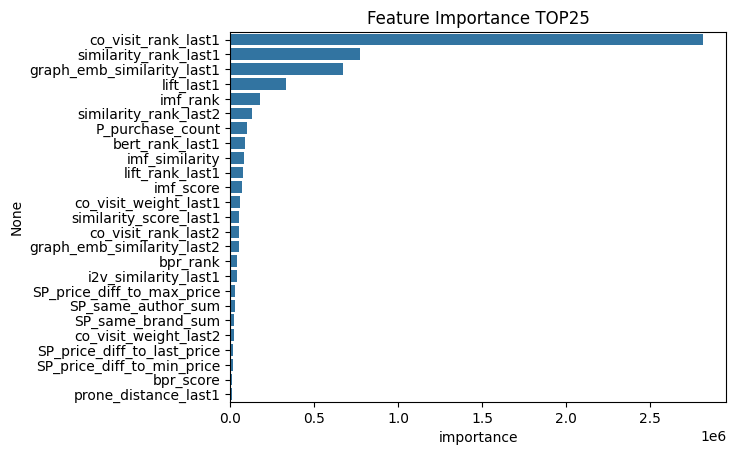

In [ ]:
%%time
# train lgbm model
feat_imp = train_lgb_model(train)

# visualize feature importances
fi_df = pd.DataFrame(index=USE_FEATURES)
fi_df["importance"] = feat_imp / K_FOLDS
fi_df = fi_df.sort_values(by="importance", ascending=False).head(25)
sns.barplot(x="importance", y=fi_df.index, data=fi_df).set(title="Feature Importance TOP25")